# Comparison of diffraction-limited Bigre and Tiger MLA psf grids

*A. Bolton, 2023 Apr*

 * Define end-to-end optical system for Tiger and Bigre configurations
   + Telescope
   + Microlens array
   + Spectrograph
   + Detector
 * Compute & compare grid of spectrograph PSFs across the MLA for a given wavelength and centering of the telescope PSF on the MLA


In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
#from poppy.sub_sampled_optics import Subapertures, ShackHartmannWavefrontSensor
import astropy.units as u
import astropy.io.fits as fits
import copy

In [2]:
# End-to-end model parameters

# Telescope:
fl_pri = 3607.5 * u.m  # primary beam focal length (effective, after magnifier)
diam = 6.5 * u.m       # primary aperture diameter
sec_rad = 0.65 * u.m   # secondary radius
n_supp = 3             # number of secondary supports
supp_wid = 0.15 * u.m  # width of secondary supports

# Common MLA parameters:
spaxel_size = 700.e-6 * u.m   # spaxel size
spaxel_arcsec = (206265. * spaxel_size / fl_pri).value # spaxel size in arcsec (COMPUTED)

# Tiger MLA parameters:
fl_tiger = 11.1e-3 * u.m         # focal length of Tiger MLA lenslet
dsize_tiger = 100.e-6 * u.m   # size of Tiger diaphragm mask aperture
imdist_tiger = 1./(1./fl_tiger - 1./fl_pri) # Tiger micropupil image distance (COMPUTED)

# Bigre MLA parameters:
fl_bigre_1 = 14.68e-3 * u.m  # focal length of first Bigre MLA lenslet
fl_bigre_2 = 0.42e-3 * u.m   # focal length of second Bigre MLA lenslet
dsize_bigre = 30.e-6 * u.m   # size of Bigre diaphragm mask aperture
imdist_bigre = fl_bigre_2*(1.+fl_bigre_2/fl_bigre_1) # Bigre microslit image distance (COMPUTED)

# Spectrograph parameters:

#### Old form of specification, possibly buggy:
## imdist_spec = 250.e-3 * u.m # Quantity called "focal length" but interpreted as not exactly that
## fratio_spec = 8             # Spectrograph focal ratio
## fl_m1m3 = 0.5 * imdist_spec # Focal length of m1 & m3 (COMPUTED)
## dsize_m2 = 40.e-3 * u.m     # Size of m2
## offset_m2 = fratio_spec * dsize_m2 - imdist_spec # offset of m2 from m1 & m3 (COMPUTED)
## fl_m2 = 0.5 * (offset_m2 - imdist_spec) # focal length of m2 (negative) (COMPUTED)

#### New form of specification:
#### [for offset_m2 cf. zemax & np.hypot(358.20-182.96,85.545-59.665) = 177.14]
roc_m1m3 = -351.4938e-3 * u.m   # Radius of curvature of (concave) m1 & m3
roc_m2 = 164.3909e-3 * u.m      # Radius of curvature of (convex) m2
fl_m1m3 = -0.5 * roc_m1m3       # Focal length of m1 & m3 (COMPUTED)
fl_m2 = -0.5 * roc_m2           # Focal length of m2 (COMPUTED)
offset_m2 = -roc_m1m3 - roc_m2  # Notional m2 offset from m1/m3 (COMPUTED)
imdist_spec = -roc_m1m3         # image/object-plane distances from m1 & m3 (COMPUTED)
dsize_m2 = 45.e-3 * u.m         # Diameter of m2
dsize_m1m3 = 270.e-3 * u.m      # Diameter of m1/m3 (CURRENTLY NOT USED)
fratio_spec = (imdist_spec - offset_m2) / dsize_m2 # sepctrograph focal ratio (COMPUTED, CURRENTLY NOT USED)

# Detector parameters:
detscale = 1. * u.micron/u.pixel  # pixel scale of detector (nominal = 10um/pix; finer to super-resolve)
#detfov = 64 * u.pixel             # number of pixels across detector
detfov = 100 * u.pixel             # number of pixels across detector

# Computational parameters:
npix = 1024              # number of pixels across pupil
pupil_diam = 2. * diam   # Diameter of area to sample

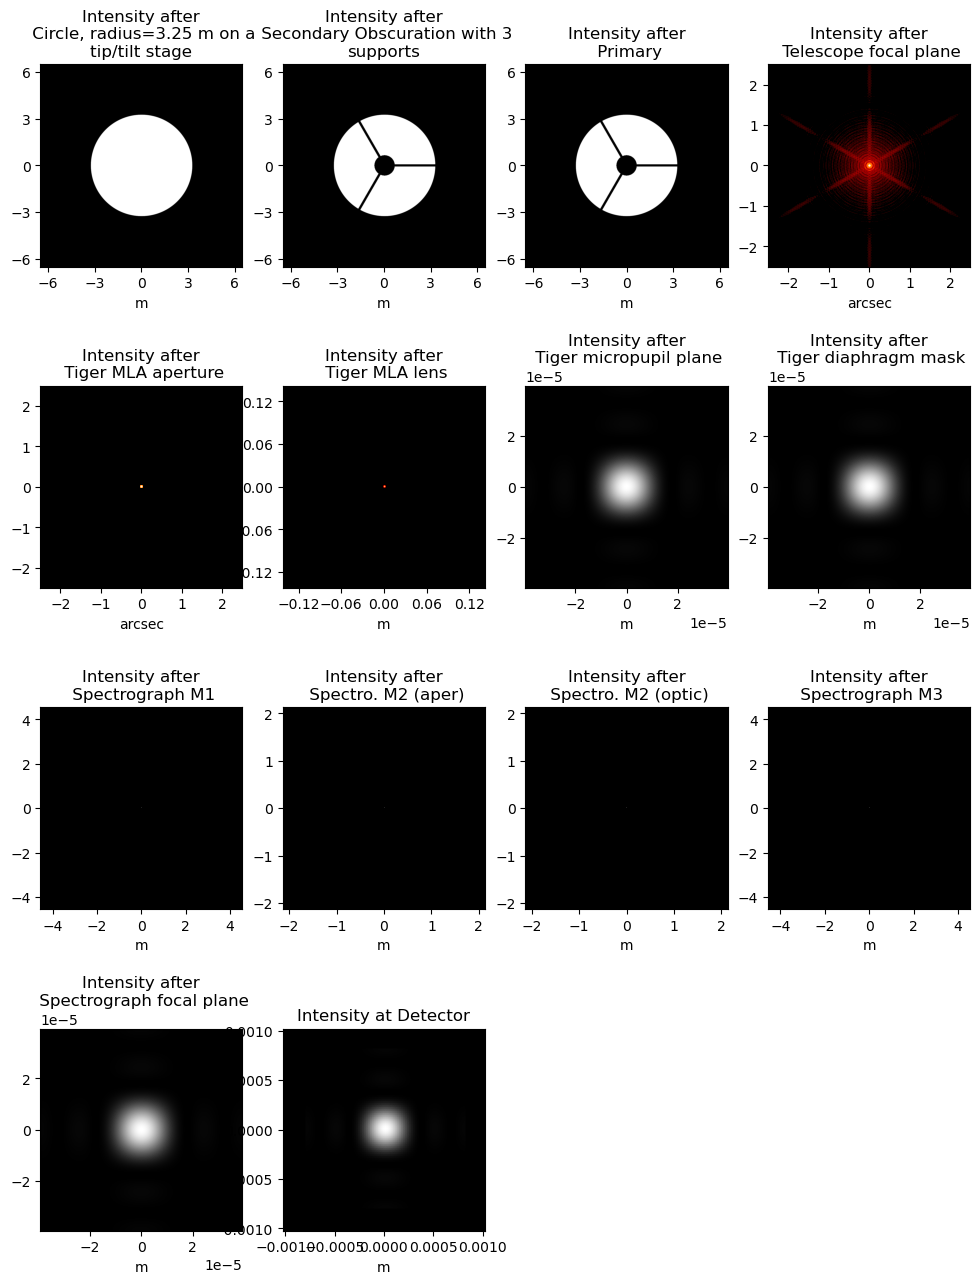

In [3]:
# DEFINE TIGER VERSION

sys_tiger = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_tiger.add_optic(ttstage)
# Include secondary obscuration:
sys_tiger.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_tiger.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_tiger.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Tiger MLA aperture'))
# Add MLA lens:
sys_tiger.add_optic(poppy.QuadraticLens(fl_tiger, name='Tiger MLA lens'))
# Define micropupil image plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Tiger micropupil plane'),
                    distance=imdist_tiger)
# Add diaphragm mask:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_tiger,  ### <---FIX?!
                                          name='Tiger diaphragm mask'))
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=imdist_spec)
# Add spectrograph M2 aperture:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=imdist_spec)
# Add detector:
sys_tiger.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_tiger.planes)):
    sys_tiger.planes[iplane].wavefront_display_hint = 'intensity'

# Tip/tilt if you want it (specified in units of spaxel):
x_shift = 0.0
y_shift = 0.0
sys_tiger[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                          y_shift * spaxel_arcsec * u.arcsec)

plt.figure(figsize=(12,16))
psf, waves = sys_tiger.calc_psf(wavelength=1.0*u.micron,
                                display_intermediates=True,
                                return_intermediates=True)

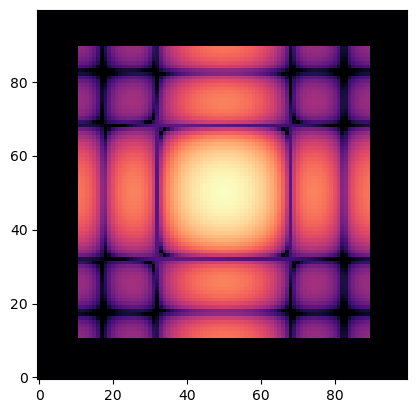

In [4]:
# Display centered PSF:

disp_image = waves[-1].intensity
disp_image /= disp_image.max()
plt.imshow(np.log10(np.maximum(disp_image, 1.e-8)), vmin = -6, vmax=0, cmap='magma', origin='lower', interpolation='nearest')

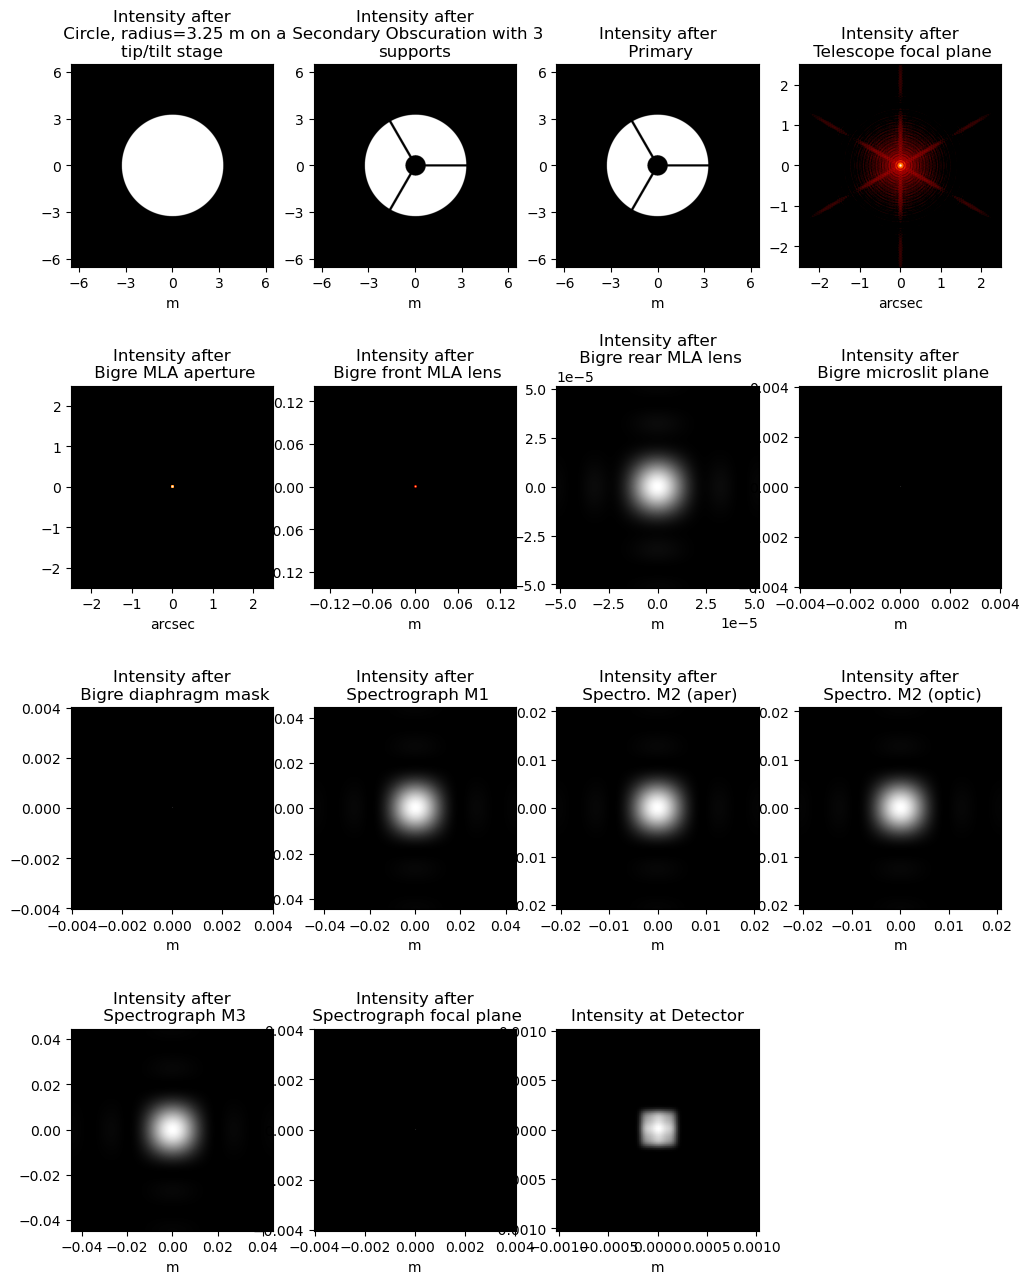

In [5]:
# DEFINE BIGRE VERSION

sys_bigre = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_bigre.add_optic(ttstage)
# Include secondary obscuration:
sys_bigre.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_bigre.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_bigre.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Bigre MLA aperture'))
# Add front Bigre MLA lens:
sys_bigre.add_optic(poppy.QuadraticLens(fl_bigre_1, name='Bigre front MLA lens'))
# Add rear Bigre MLA lens:
sys_bigre.add_optic(poppy.QuadraticLens(fl_bigre_2, name='Bigre rear MLA lens'),
                    distance=(fl_bigre_1+fl_bigre_2))

# Define microslit image plane:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Bigre microslit plane'),
                    distance=imdist_bigre)
# Add diaphragm mask:
sys_bigre.add_optic(poppy.SquareAperture(size=1.*dsize_bigre,  ### <---FIX?!
                                          name='Bigre diaphragm mask'))
sys_bigre.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_bigre.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=imdist_spec)
# Add spectrograph M2 aperture:
sys_bigre.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_bigre.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_bigre.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=1.*imdist_spec)
# Add detector:
sys_bigre.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_bigre.planes)):
    sys_bigre.planes[iplane].wavefront_display_hint = 'intensity'

# Tip/tilt if you want it (specified in units of spaxel):
x_shift = 0.
y_shift = 0.
sys_bigre[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                          y_shift * spaxel_arcsec * u.arcsec)

plt.figure(figsize=(12,16))
psf, waves = sys_bigre.calc_psf(wavelength=1.*u.micron,
                                display_intermediates=True,
                                return_intermediates=True)

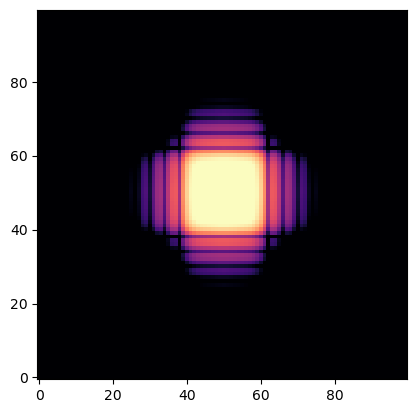

In [6]:
# Display centered PSF:

disp_image = waves[-1].intensity
disp_image /= disp_image.max()
plt.imshow(np.log10(np.maximum(disp_image, 1.e-8)), vmin = -6, vmax=-.5, cmap='magma', origin='lower', interpolation='nearest')

In [7]:
# Compute comparable MLA grids for Bigre and Tiger

grid_hw = 2  # "half-width" of the lenslet grid in lenslets (2*grid_hw+1 is full width)
det_npix = int(detfov.value)  # integer dimension of detector in pixels
grid_npix = det_npix * (2 * grid_hw + 1)  # how many pixels total in the image
x_sub = 0.2 # x subspax offset of the PSF relative to the center of the central spaxel
y_sub = 0.4 # y subspax offset of the PSF relative to the center of the central spaxel
calc_wave = 1.0 * u.micron  # wavelength for which to calculate

# Initialize Bigre and Tiger PSF mosaic grids:
psf_mosaic_b = np.full((grid_npix, grid_npix), 0.)  # y-dimension [comma] x-dimension
psf_mosaic_t = np.full((grid_npix, grid_npix), 0.)  # y-dimension [comma] x-dimension

for y_this in range(2*grid_hw+1):
    y_shift = y_this - grid_hw + y_sub
    y_lo = (2*grid_hw - y_this) * det_npix      # Accommodate odd-reflection between
    y_hi = (2*grid_hw - y_this + 1) * det_npix  # MLA focus and spectrograph focus
    for x_this in range(2*grid_hw+1):
        x_shift = x_this - grid_hw + x_sub
        x_lo = (2*grid_hw - x_this) * det_npix
        x_hi = (2*grid_hw - x_this + 1) * det_npix
        print(x_shift, y_shift)
        sys_bigre[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                                  y_shift * spaxel_arcsec * u.arcsec)
        sys_tiger[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                                  y_shift * spaxel_arcsec * u.arcsec)
        psf_b, fwave_b = sys_bigre.calc_psf(wavelength=calc_wave,
                                            display_intermediates=False,
                                            return_intermediates=False,
                                            return_final=True)
        psf_t, fwave_t = sys_tiger.calc_psf(wavelength=calc_wave,
                                            display_intermediates=False,
                                            return_intermediates=False,
                                            return_final=True)
        psf_mosaic_b[y_lo:y_hi,x_lo:x_hi] = fwave_b[0].intensity
        psf_mosaic_t[y_lo:y_hi,x_lo:x_hi] = fwave_t[0].intensity

-1.8 -1.6
-0.8 -1.6
0.2 -1.6
1.2 -1.6
2.2 -1.6
-1.8 -0.6
-0.8 -0.6
0.2 -0.6
1.2 -0.6
2.2 -0.6
-1.8 0.4
-0.8 0.4
0.2 0.4
1.2 0.4
2.2 0.4
-1.8 1.4
-0.8 1.4
0.2 1.4
1.2 1.4
2.2 1.4
-1.8 2.4
-0.8 2.4
0.2 2.4
1.2 2.4
2.2 2.4


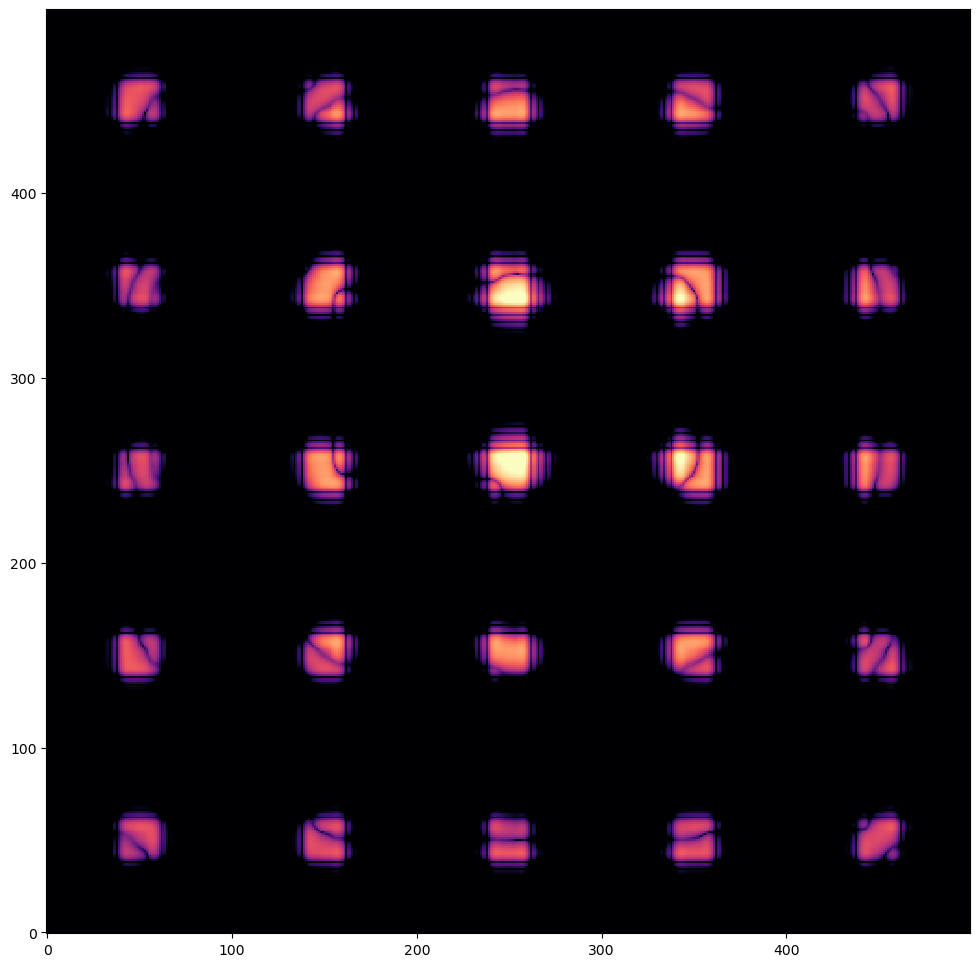

In [8]:
# Display Bigre grid:

psf_norm_b = psf_mosaic_b / psf_mosaic_b.max()
plt.figure(figsize=(12,12))
plt.imshow(np.log10(np.maximum(psf_norm_b, 1.e-8)), vmin = -6, vmax=-.5, cmap='magma', origin='lower', interpolation='nearest')

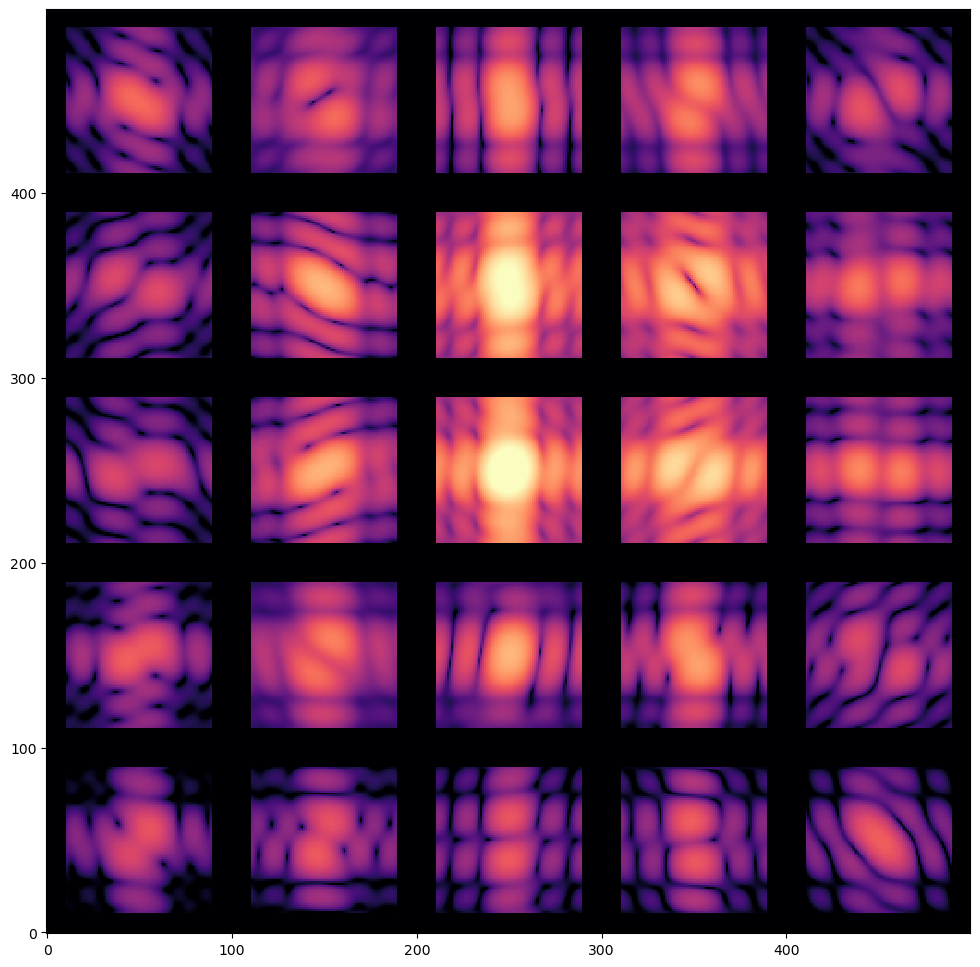

In [9]:
# Display Tiger grid:

psf_norm_t = psf_mosaic_t / psf_mosaic_t.max()
plt.figure(figsize=(12,12))
plt.imshow(np.log10(np.maximum(psf_norm_t, 1.e-8)), vmin = -6, vmax=-.5, cmap='magma', origin='lower', interpolation='nearest')